## Description of the Problem

In [475]:
# The objective of this project is to implement a framework where the knowedge of bayesian uncertainty can be combined with Deep Learning Models
# The original idea of incorporating bayesian statistics in deep learning models was proposed by Yarin Gal (2016), and here we shall implement that concept utilising the capability of dropout layers to add uncertainty to the model outcome during testing
# The data for this project has been downloaded from https://www.isic-archive.com/#!/topWithHeader/wideContentTop/main
# This is an image data set comprising of malignant and non-malignant skin cancers, and has both binary (Melanoma/Other) as well as multi-class classification labels
# For the purpose of this project, we will use binary labels and assess the change in accuracy of the model for scenarios where the model can predict the outcome witout uncertainty, v/s when the model declares its uncertainty about the outcome
# We have developed our own custom model, and have also assessed the performance of three transfer learning models: MobileNet, DenseNet and NASNet
# We finally used DenseNet201 on the Test Sample and for incorporating the uncertainty, because it was performing the best on training and validation data 

## Environment

In [1]:
# We utilised Google's cloud platform (https://cloud.google.com) to develop our models, test and train them
# The first step was to import the image data set and the .csv file containing the image labels to the working directory
# Once the folder containing image files (ISIC_2019_Training_Input) and the .csv file containing the image labels (ISIC_2019_Training_GroundTruth.csv) have been imported to the working directory, the following code would first create data frame containing binary labels for the corresponding image filenames
# These filenames are then used by the image generator to load random samples of images for test and validation, and the binary labels are used from the labels created earlier

## Importing all Libraries

In [1]:
#Importing Utilities
import os
from glob import glob
import copy
import os
import time
import datetime
from PIL import Image
import sys
import warnings
warnings.filterwarnings("ignore")
import json,codecs

# data tools
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tqdm

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dense, Dropout, Input,Conv2D, MaxPooling2D, BatchNormalization
import sklearn.model_selection as model_selection
import keras
import tensorflow as tf

#Metrics
from sklearn.metrics import precision_score , recall_score
from  tensorflow.keras.models import Sequential, Model
from keras.metrics import binary_accuracy
from keras.metrics import categorical_accuracy
from sklearn.metrics import roc_curve, auc

#Transfer learning models
from keras.applications.densenet import DenseNet201
from keras.applications.nasnet import NASNetMobile
from keras.applications.mobilenet import MobileNet 

plt.style.use("ggplot")
%matplotlib inline

%matplotlib inline

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Defining the Data Loader for generating image label dataframe

In [2]:
def processLabelDf(file):
    # load file into df and set image name as index
    df = pd.read_csv(file)
    df = df.set_index("image")

    # create list of class labels from column header
    classes = df.columns

    # create multiclass and binary class labels, remove original columns
    df["multi"] = ""
    for label in classes:
        df["multi"] = np.where(df[label] == 1, label, df["multi"])
        df = df.drop(label, axis=1)

    df["binary"] = np.where(df["multi"] == "MEL", "MEL", "NONMEL")

    return df

## Loading File names from directory and generating labels data frame using function described earlier

In [3]:
labelDf = processLabelDf(
    file="ISIC_2019_Training_GroundTruth.csv"
)
labelDf[:10]

,multi,binary
image,,
ISIC_0000000,NV,NONMEL
ISIC_0000001,NV,NONMEL
ISIC_0000002,MEL,MEL
ISIC_0000003,NV,NONMEL
ISIC_0000004,MEL,MEL
ISIC_0000006,NV,NONMEL
ISIC_0000007,NV,NONMEL
ISIC_0000008,NV,NONMEL
ISIC_0000009,NV,NONMEL


In [4]:
a=labelDf.sample(frac=1)
Train = a[:20000]
Test = a[20001:]

In [5]:
Test['image'] = Test.index

In [6]:
for i in range(len(Test)):
    Test['image'][i]=Test['image'][i]+".jpg"

In [7]:
Test.columns

Index(['multi', 'binary', 'image'], dtype='object')

## Loading Test Image Generator

In [8]:
datagen = ImageDataGenerator(
    rescale = 1/255,
    rotation_range = 270,
    horizontal_flip = True,
    validation_split=00.0)

In [9]:
test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
    dataframe=Test,
    directory="./ISIC_2019_Training_Input",
    x_col="image",
    y_col="binary",
    batch_size=100,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(256,256))

Found 5330 validated image filenames belonging to 2 classes.


## Loading 100 test images

In [10]:
Test_img, Test_lab = test_generator.next()
pd.DataFrame(Test_lab)[0].value_counts() / len(Test_lab)

0.0    0.73
1.0    0.27
Name: 0, dtype: float64

In [11]:
len(Test_lab)

100

## Testing on the Densenet Model which performed best on the validation data 

In [12]:
Testing_Model = tf.keras.models.load_model('./Deep Learning Project_Dr50/DenseNet_model_dr_final_50_13_12.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
Predictions = Testing_Model.predict(Test_img)

## Inverting(Correcting) Predictions and Labels (1=Melanoma; 0=Non-Melanoma)
(So that Pred_bin variables yields 1 for Melanoma and 0 for Non-Melanoma)

In [14]:
for i in range(len(Predictions)):
    temp=Predictions[i][0]
    Predictions[i][0]=Predictions[i][1]
    Predictions[i][1]=temp

In [15]:
Pred_bin=[]
for y_p in Predictions:
    p = y_p.argmax(axis=0)
    Pred_bin.append(p)

## Model Accuracy on Test Set

In [18]:
accs = 0
for i in range(len(Pred_bin)):
    if(pd.DataFrame(Test_lab)[0][i]== Pred_bin[i]):
      accs=accs+1  
print("Accuracy on the Test Sample for the Best Model: {:.1%}".format((accs)/len(Pred_bin)))

Accuracy on the Test Sample for the Best Model: 83.0%


## Initial Predictions before accounting for Model Uncertainty

In [19]:
y_score = []
for index in range(len(Test_lab)): #compute one at a time due to memory constraints
    print("Predicted values..." + "Melanoma : ", Predictions[index][1], " | Other : ", Predictions[index][0])
    print("Real values..." + "Melanoma : ", Test_lab[index][0], " | Other : ", Test_lab[index][1])
    print("---------------------------------------------------------------------------")


Predicted values...Melanoma :  0.0  | Other :  1.0
Real values...Melanoma :  0.0  | Other :  1.0
---------------------------------------------------------------------------
Predicted values...Melanoma :  0.0011755447  | Other :  0.9988244
Real values...Melanoma :  0.0  | Other :  1.0
---------------------------------------------------------------------------
Predicted values...Melanoma :  0.9041531  | Other :  0.09584682
Real values...Melanoma :  0.0  | Other :  1.0
---------------------------------------------------------------------------
Predicted values...Melanoma :  1.5315034e-05  | Other :  0.99998474
Real values...Melanoma :  0.0  | Other :  1.0
---------------------------------------------------------------------------
Predicted values...Melanoma :  0.014484862  | Other :  0.9855151
Real values...Melanoma :  0.0  | Other :  1.0
---------------------------------------------------------------------------
Predicted values...Melanoma :  0.05423779  | Other :  0.9457622
Real values.

## Defining ROC Function

In [20]:
def compute_roc(y_true, y_score):
    """ 
    Computing the "Receiving Operating Characteristic curve" and area
    """
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, y_score) 
    auroc = auc(false_positive_rate, true_positive_rate) 
    return false_positive_rate, true_positive_rate, auroc

## Plotting the ROC

In [21]:
def plot_roc(y_true, y_score):
    """ 
    Ploting the Receiving Operating Characteristic curve
    """
    false_positive_rate, true_positive_rate, auroc = compute_roc(y_true, y_score)
    plt.figure(figsize=(10,6))
    plt.grid()
    plt.plot(false_positive_rate, 
             true_positive_rate, 
             color='darkorange',
             lw=2, 
             label='ROC curve (area = {:.2f})'.format(auroc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver operating characteristic example', fontsize=15)
    plt.legend(loc="lower right", fontsize=14)
    plt.show()

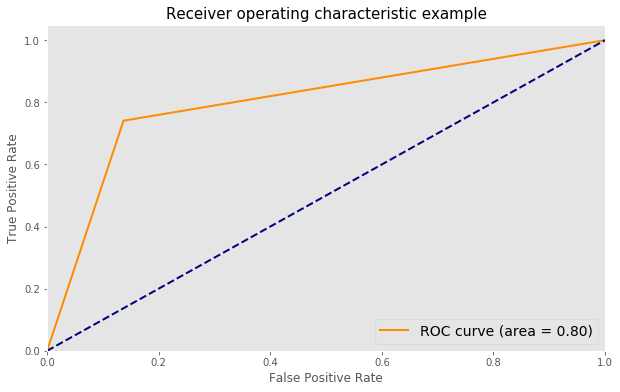

In [22]:
plot_roc(pd.DataFrame(Test_lab)[0],Pred_bin)

## Calculating the True Positives, True Negatives, False Positives, False Negatives

In [23]:
def positive_negative_measurement(y_true, y_score):
    # Initialization
    TRUE_POSITIVE = 0
    FALSE_POSITIVE = 0
    TRUE_NEGATIVE = 0
    FALSE_NEGATIVE = 0
    
    # Calculating the model
    for i in range(len(y_score)):
        if y_true[i] == y_score[i] == 1:
            TRUE_POSITIVE += 1
        if (y_score[i] == 1) and (y_true[i] != y_score[i]):
            FALSE_POSITIVE += 1
        if y_true[i] == y_score[i] == 0:
            TRUE_NEGATIVE += 1
        if (y_score[i] == 0) and (y_true[i] != y_score[i]):
            FALSE_NEGATIVE += 1

    return(TRUE_POSITIVE, FALSE_POSITIVE, TRUE_NEGATIVE, FALSE_NEGATIVE)

In [24]:
TRUE_POSITIVE, FALSE_POSITIVE, TRUE_NEGATIVE, FALSE_NEGATIVE = positive_negative_measurement(pd.DataFrame(Test_lab)[0],Pred_bin)
postives_negatives = [[TRUE_POSITIVE, FALSE_POSITIVE], 
                      [FALSE_NEGATIVE, TRUE_NEGATIVE]]

## Displaying the Confusion Matrix before accounting for uncertaintly

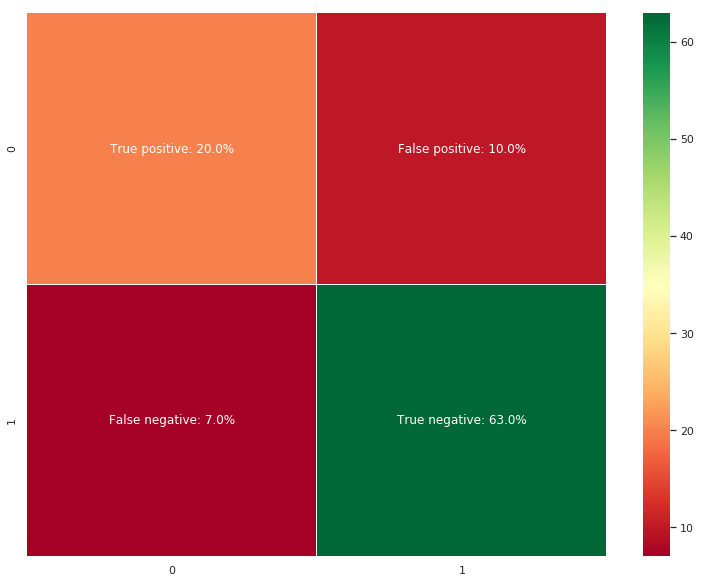

In [25]:
sns.set()
labels =  np.array([['True positive: ' + str(TRUE_POSITIVE*100/(TRUE_POSITIVE+FALSE_POSITIVE+FALSE_NEGATIVE+TRUE_NEGATIVE))+"%",
                     'False positive: ' + str(FALSE_POSITIVE*100/(TRUE_POSITIVE+FALSE_POSITIVE+FALSE_NEGATIVE+TRUE_NEGATIVE))+"%"],
                    ['False negative: ' + str(FALSE_NEGATIVE*100/(TRUE_POSITIVE+FALSE_POSITIVE+FALSE_NEGATIVE+TRUE_NEGATIVE))+"%",
                     'True negative: ' + str(TRUE_NEGATIVE*100/(TRUE_POSITIVE+FALSE_POSITIVE+FALSE_NEGATIVE+TRUE_NEGATIVE))+"%"]])
plt.figure(figsize = (13, 10))
sns.heatmap(postives_negatives, annot = labels, linewidths = 0.1, fmt="", cmap = 'RdYlGn')

## Model Recall, Precision and F1 Score before accounting for uncertaintly

In [26]:
#True Positive Rate/Recall
Recall = TRUE_POSITIVE / (TRUE_POSITIVE + FALSE_NEGATIVE)
print("Model Recall: ", Recall)

Model Recall:  0.7407407407407407


In [27]:
# Precision | positive predictive value (PPV)
precision = TRUE_POSITIVE / (TRUE_POSITIVE + FALSE_POSITIVE)
print("Precision: ", precision)

Precision:  0.6666666666666666


In [28]:
F1 = 2*precision*Recall/(precision+Recall)
print("F1 value: ", F1)

F1 value:  0.7017543859649122


## Running the Monte Carlo Simulations to Obtain Model Uncertainty through distribution of outcomes

In [29]:
MC_Predictions = []
MC_Predictions_bin=[]
for i in tqdm.tqdm(range(500)):
    y_p = Testing_Model.predict(Test_img)
    Y_bin = y_p.argmax(axis=0)
    MC_Predictions .append(y_p)
    MC_Predictions_bin.append(Y_bin)

100%|██████████| 500/500 [03:49<00:00,  2.18it/s]


In [30]:
for i in range(len(MC_Predictions)):
    for j in range(len(MC_Predictions[0])):
        temp=MC_Predictions[i][j][0]
        MC_Predictions[i][j][0]=MC_Predictions[i][j][1]
        MC_Predictions[i][j][1]=temp

In [31]:
accs = []
for y_p in MC_Predictions:
    acc = accuracy_score(pd.DataFrame(Test_lab)[0], y_p.argmax(axis=1))
    accs.append(acc)
print("Accuracy: {:.1%}".format(sum(accs)/len(accs)))

Accuracy: 83.9%


## Visualising the accuracies for different simulations

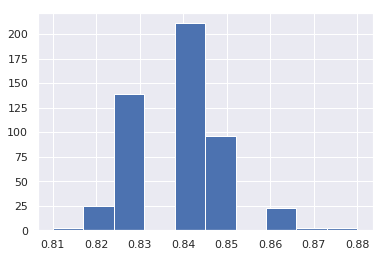

In [32]:
plt.hist(accs);

## Let us calculate mean melanoma probability for a random image 

Text(0.5, 1.0, 'Image 18')

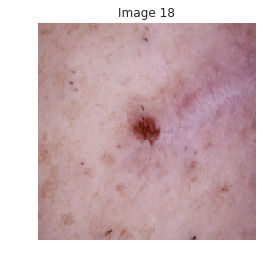

In [33]:
img = 18
plt.imshow(Test_img[img][:,:,:])
plt.axis('off')
plt.title("Image 18")

In [36]:
p0 = np.array([p[img] for p in MC_Predictions])
print("Calculated Label: {}".format(p0.mean(axis=0).argmax()))
print("True label: {}".format(1-(Test_lab[img].argmax())))
print()
# probability + variance
for i, (prob, var) in enumerate(zip(p0.mean(axis=0), p0.std(axis=0))):
    print("class: {}; probability: {:.1%}; Variance: {:.2%} ".format(i, prob, var))

Calculated Label: 0
True label: 0

class: 0; probability: 99.8%; Variance: 0.20% 
class: 1; probability: 0.2%; Variance: 0.20% 


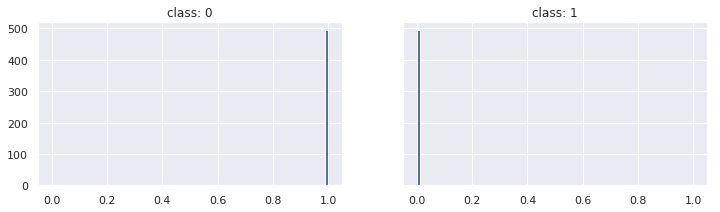

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12,3))

for i, ax in enumerate(fig.get_axes()):
    ax.hist(p0[:,i], bins=100, range=(0,1))
    ax.set_title( "class: {}".format(i))
    ax.label_outer()

## Let us find the image for which the model's uncertainty is the highest (In terms of probability)

In [38]:
max_means = []
preds = []
for idx in range(len(MC_Predictions[0])):
    px = np.array([p[idx] for p in MC_Predictions])
    preds.append(px.mean(axis=0).argmax())
    max_means.append(px.mean(axis=0).max())

In [39]:
Most_Uncertain=(np.array(max_means)).argsort()[:10]

Text(0.5, 1.0, 'Image 32: Most Uncertain Outcome')

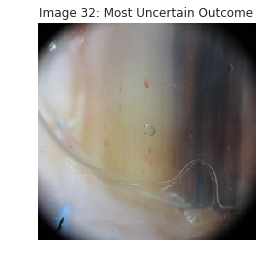

In [40]:
plt.imshow(Test_img[Most_Uncertain[0]][:,:,:])
plt.axis('off')
plt.title("Image {}: Most Uncertain Outcome".format(Most_Uncertain[0]))

## Let us visualise the images and probability distribution for the two classes for most uncertain classifications based on the monte carlo simulation

In [41]:
Most_Certain=(np.array(max_means)).argsort()[10:]

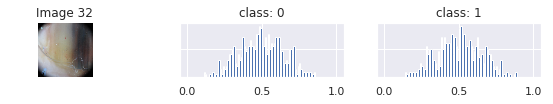

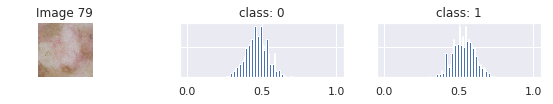

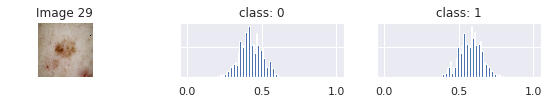

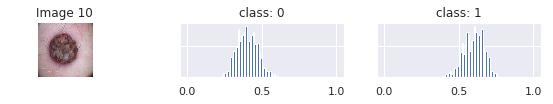

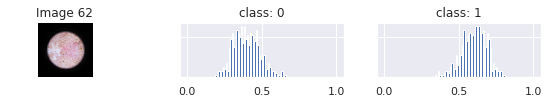

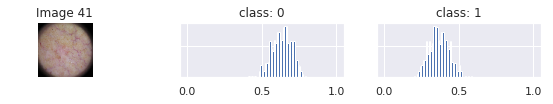

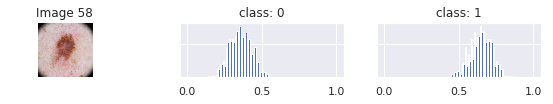

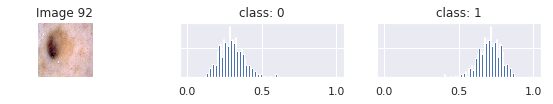

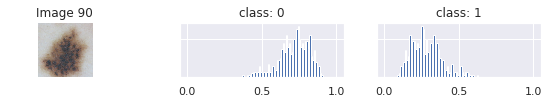

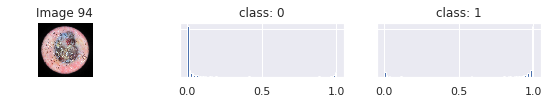

In [42]:
for i in range(len(Most_Uncertain)):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (10, 1))

    ax[0].imshow(Test_img[Most_Uncertain[i]])
    ax[0].set_title( "Image {}".format(Most_Uncertain[i]))
    ax[0].axis('off')
    p = np.array([p[Most_Uncertain[i]] for p in MC_Predictions])
    ax[1].hist(p[:,0], bins=100, range=(0,1))
    ax[1].set_title( "class: {}".format(0))
    ax[1].label_outer()
    ax[2].hist(p[:,1], bins=100, range=(0,1))
    ax[2].set_title( "class: {}".format(1))
    ax[2].label_outer()

## Let us visualise the images and probability distribution for the two classes for most certain classifications based on the monte carlo simulation

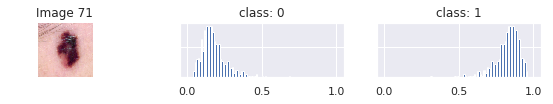

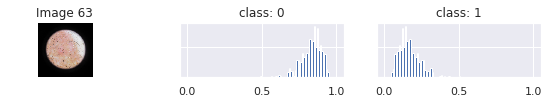

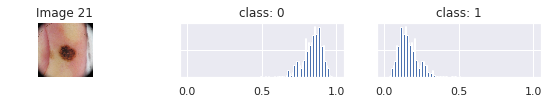

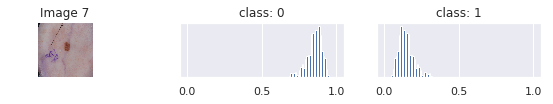

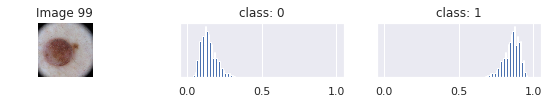

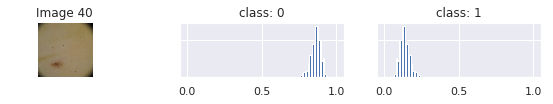

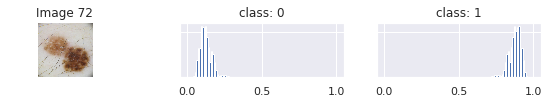

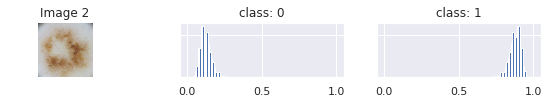

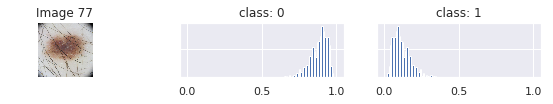

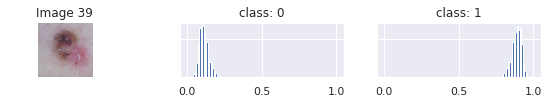

In [43]:
for i in range(len(Most_Uncertain)):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (10, 1))

    ax[0].imshow(Test_img[Most_Certain[i]])
    ax[0].set_title( "Image {}".format(Most_Certain[i]))
    ax[0].axis('off')
    p = np.array([p[Most_Certain[i]] for p in MC_Predictions])
    ax[1].hist(p[:,0], bins=100, range=(0,1))
    ax[1].set_title( "class: {}".format(0))
    ax[1].label_outer()
    ax[2].hist(p[:,1], bins=100, range=(0,1))
    ax[2].set_title( "class: {}".format(1))
    ax[2].label_outer()

## Let us assume that the model uses 95% as the threshold for uncertain outcomes. 
## All outcomes for which classification probability is less than 95% would be deemed uncertain by the model, instead of classifying uncertain outcomes
## So only the outcomes where model certainty>95% would be used to calculate accuracy, for remaining cases, model does not provide outcome
## The probabilities have been calculated using monte carlo simulation and thus present a statistical element to the problem of classification

In [44]:
Model_Confidence = .95

In [45]:
len(MC_Predictions[0])

100

In [46]:
inverse=[]
for i in  range(len(MC_Predictions[0])):
    temp2=[]
    for j in range(len(MC_Predictions)):
        temp = MC_Predictions[j][i]
        temp2.append(temp)
    inverse.append(temp2)
        

In [47]:
Y_Certain_Lab=[]
Y_Certain_Pred=[]
Not_Certain=[]
for j in range(len(max_means)):
    if max_means[j]>Model_Confidence:
        Y_Certain_Lab.append(pd.DataFrame(Test_lab)[0][j])
        Y_Certain_Pred.append(Pred_bin[j])
        Not_Certain.append(1000)
    else:
        Not_Certain.append(j)
        

## ROC goes up when we only allow model to provide certain outcomes

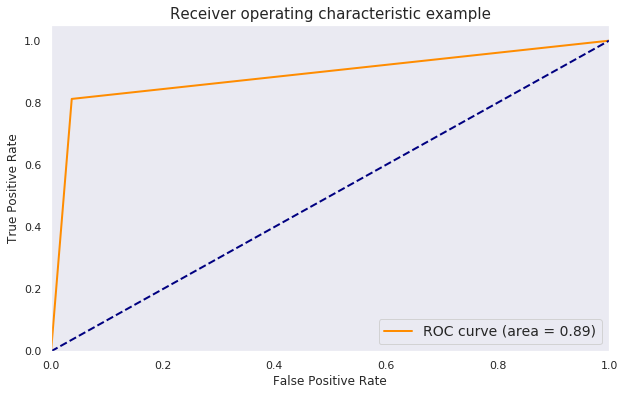

In [48]:
plot_roc(Y_Certain_Lab,Y_Certain_Pred)

In [49]:
def positive_negative_measurement(y_true, y_score):
    # Initialization
    TRUE_POSITIVE = 0
    FALSE_POSITIVE = 0
    TRUE_NEGATIVE = 0
    FALSE_NEGATIVE = 0
    
    # Calculating the model
    for i in range(len(y_score)):
        if y_true[i] == y_score[i] == 1:
            TRUE_POSITIVE += 1
        if (y_score[i] == 1) and (y_true[i] != y_score[i]):
            FALSE_POSITIVE += 1
        if y_true[i] == y_score[i] == 0:
            TRUE_NEGATIVE += 1
        if (y_score[i] == 0) and (y_true[i] != y_score[i]):
            FALSE_NEGATIVE += 1

    return(TRUE_POSITIVE, FALSE_POSITIVE, TRUE_NEGATIVE, FALSE_NEGATIVE)

In [50]:
TRUE_POSITIVE, FALSE_POSITIVE, TRUE_NEGATIVE, FALSE_NEGATIVE = positive_negative_measurement(Y_Certain_Lab,Y_Certain_Pred)
postives_negatives = [[TRUE_POSITIVE, FALSE_POSITIVE], 
                      [FALSE_NEGATIVE, TRUE_NEGATIVE]]

## We can clearly see an increase in Precision, Recall and F1 value

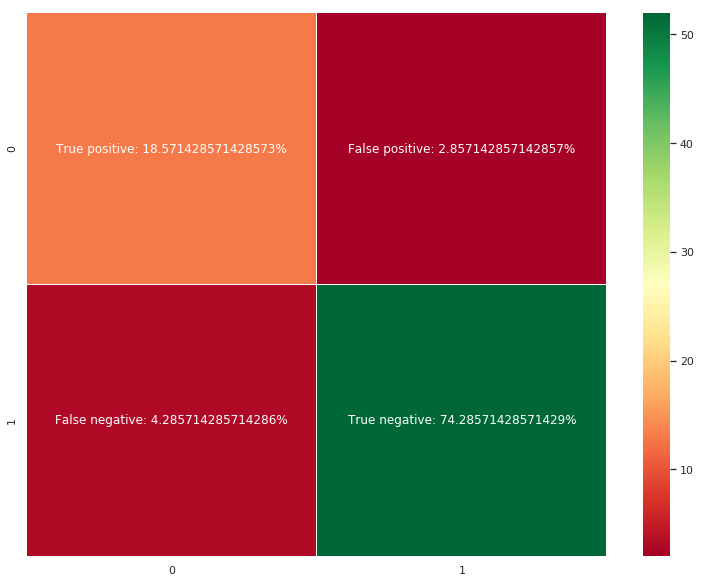

In [51]:
import seaborn as sns
sns.set()
labels =  np.array([['True positive: ' + str(TRUE_POSITIVE*100/(TRUE_POSITIVE+FALSE_POSITIVE+FALSE_NEGATIVE+TRUE_NEGATIVE))+"%",
                     'False positive: ' + str(FALSE_POSITIVE*100/(TRUE_POSITIVE+FALSE_POSITIVE+FALSE_NEGATIVE+TRUE_NEGATIVE))+"%"],
                    ['False negative: ' + str(FALSE_NEGATIVE*100/(TRUE_POSITIVE+FALSE_POSITIVE+FALSE_NEGATIVE+TRUE_NEGATIVE))+"%",
                     'True negative: ' + str(TRUE_NEGATIVE*100/(TRUE_POSITIVE+FALSE_POSITIVE+FALSE_NEGATIVE+TRUE_NEGATIVE))+"%"]])
plt.figure(figsize = (13, 10))
sns.heatmap(postives_negatives, annot = labels, linewidths = 0.1, fmt="", cmap = 'RdYlGn')

In [52]:
#True Positive Rate/Recall
Recall = TRUE_POSITIVE / (TRUE_POSITIVE + FALSE_NEGATIVE)

# Precision | positive predictive value (PPV)
precision = TRUE_POSITIVE / (TRUE_POSITIVE + FALSE_POSITIVE)

F1 = 2*precision*Recall/(precision+Recall)


In [53]:
print("Model Recall: ", Recall)
print("Precision: ", precision)
print("F1 value: ", F1)

Model Recall:  0.8125
Precision:  0.8666666666666667
F1 value:  0.8387096774193549


## Here is how the new outcome would look like in this Bayesian classification

In [60]:
y_score = []
for index in range(len(Test_lab)): #compute one at a time due to memory constraints
    if(index==Not_Certain[index]):
        print("Model is not sure about the outcome with >95% Certainty about Image Number",index)
        print("---------------------------------------------------------------------------")
    else:
        print("Predicted values..." + "Melanoma : ", Predictions[index][0], " | Other : ", Predictions[index][1])
        print("Real values..." + "Melanoma : ", Test_lab[index][1], " | Other : ", Test_lab[index][0])
        print("---------------------------------------------------------------------------")

Predicted values...Melanoma :  1.0  | Other :  0.0
Real values...Melanoma :  1.0  | Other :  0.0
---------------------------------------------------------------------------
Predicted values...Melanoma :  0.9988244  | Other :  0.0011755447
Real values...Melanoma :  1.0  | Other :  0.0
---------------------------------------------------------------------------
Model is not sure about the outcome with >95% Certainty about Image Number 2
---------------------------------------------------------------------------
Predicted values...Melanoma :  0.99998474  | Other :  1.5315034e-05
Real values...Melanoma :  1.0  | Other :  0.0
---------------------------------------------------------------------------
Predicted values...Melanoma :  0.9855151  | Other :  0.014484862
Real values...Melanoma :  1.0  | Other :  0.0
---------------------------------------------------------------------------
Model is not sure about the outcome with >95% Certainty about Image Number 5
--------------------------------

## -x-x-